### Creating mask for 600m isobath separating slope and shelf regions 

Defined in Ong et al. 2025. "Transient Antarctic Slope Current Response to Climate Change including Meltwater"


In [1]:
import os

In [2]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

In [3]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
from matplotlib import rc
rc('font', **{'size':40})
rc('text', usetex=False)
rc('xtick', labelsize=40) #20 
rc('ytick', labelsize=40) #20
rc('axes', titlesize=40)    # fontsize of the axes title
rc('axes', labelsize=40) #24    # fontsize of the x and y labels

In [6]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [7]:
from dask.distributed import Client

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43477/status,
Dashboard: /proxy/43477/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44971,Workers: 7
Dashboard: /proxy/43477/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:34579,Total threads: 4
Dashboard: /proxy/40211/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:40197,


In [8]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:33447': 56,
 'tcp://127.0.0.1:34579': 56,
 'tcp://127.0.0.1:39453': 56,
 'tcp://127.0.0.1:39555': 56,
 'tcp://127.0.0.1:44615': 56,
 'tcp://127.0.0.1:45125': 56,
 'tcp://127.0.0.1:46097': 56}

In [9]:
# location limits of dataset - choosing slice near totten
lon_lim = slice(-280, 79.99)#slice(30, 45)#
lat_lim = slice(-79,-60)#slice(-70, -65)

# time periods
flex_period = slice('2000','2010')#,'slice('2000', '2060')

## Loading previously saved surface geostrophic velocity & topographic gradient files for control experiment

In [10]:
u = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/u_daily_circ_ssh_lat7960_jupyter.nc').ug_s.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
v = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/v_daily_circ_ssh_lat7960_jupyter.nc').vg_s.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
dhu_dx = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dx_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
dhu_dy = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dy_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
slope = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/slope_field.nc').__xarray_dataarray_variable__

In [11]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))
hu

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<getitem, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [12]:
# NEED load coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [13]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:33447': 172,
 'tcp://127.0.0.1:34579': 285,
 'tcp://127.0.0.1:39453': 282,
 'tcp://127.0.0.1:39555': 104,
 'tcp://127.0.0.1:44615': 329,
 'tcp://127.0.0.1:45125': 212,
 'tcp://127.0.0.1:46097': 145}

In [14]:
flex_period

slice('2000', '2010', None)

In [15]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [16]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:33447': 56,
 'tcp://127.0.0.1:34579': 56,
 'tcp://127.0.0.1:39453': 56,
 'tcp://127.0.0.1:39555': 56,
 'tcp://127.0.0.1:44615': 56,
 'tcp://127.0.0.1:45125': 56,
 'tcp://127.0.0.1:46097': 56}

## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

vel = xr.merge([coordinates, u.sel(time=flex_period), v.sel(time=flex_period), ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

vel

import gc
c.run(gc.collect)

vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

import gc
c.run(gc.collect)

hu_region = hu.sel( yu_ocean = lat_lim, xu_ocean = lon_lim)

## EKE calculation

In [ ]:
%%time

u_reshape_arr = []
for xx in range(0,6):
    u_chunk = u.isel(xu_ocean = slice(xx*600,600*(xx+1))).chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
    u_reshape_elem = u_chunk.coarsen(time=365).construct(time=('year', 'dayofyear')).mean('year').load()
    u_reshape_arr.append(u_reshape_elem)

In [ ]:
c.run(gc.collect)

In [ ]:
u_reshape = xr.merge(u_reshape_arr)

In [ ]:
u_reshape.isel(dayofyear = 0).ug_s.plot.contourf()

In [ ]:
%%time

v_reshape_arr = []
for xx in range(0,6):
    v_chunk = v.isel(xu_ocean = slice(xx*600,600*(xx+1))).chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
    v_reshape_elem = v_chunk.coarsen(time=365).construct(time=('year', 'dayofyear')).mean('year').load()
    v_reshape_arr.append(v_reshape_elem)

In [22]:
v_reshape = xr.merge(v_reshape_arr)

In [48]:
%%time
print('EKE calculating')
rho_0 = 1035 #[kg m-3]
#EKE_matrix = []
# iterating in longitude   .chunk({'time':1000, 'xu_ocean':100, 'yu_ocean':200})
for xx in range(2,12):
    c.run(gc.collect)
    
    u_transient_clim = u.isel(xu_ocean = slice(xx*300, (xx+1)*300)).groupby( 'time.dayofyear') - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
    v_transient_clim = v.isel(xu_ocean = slice(xx*300, (xx+1)*300)).groupby( 'time.dayofyear') - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
    
    u_transientsel = u_transient_clim.load()#.where(mask_bath_shelf == True)#.where(mask_bath_slopeshelf == True).where(mask_East == True)#.load()#.sel(xu_ocean = slice(ASC_slice_rect[i][1][1], ASC_slice_rect[i][2][1]), yu_ocean = slice(ASC_slice_rect[i][1][0], ASC_slice_rect[i][2][0])).load()
    print('loaded u')
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.load()#.where(mask_bath_shelf == True)#.where(mask_bath_slopeshelf == True).where(mask_East == True)#.load()#.sel(xu_ocean = slice(ASC_slice_rect[i][1][1], ASC_slice_rect[i][2][1]), yu_ocean = slice(ASC_slice_rect[i][1][0], ASC_slice_rect[i][2][0])).load()
    print('loaded v')
    
    EKE = 0.5*rho_0*(u_transientsel.ug_s**2 + v_transientsel.vg_s**2)#.load()
    print('loaded %i' ,xx)
    EKE_matrix.append(EKE)

EKE calculating
loaded u
loaded v
loaded %i 2
loaded u
loaded v
loaded %i 3
loaded u
loaded v
loaded %i 4
loaded u
loaded v
loaded %i 5
loaded u
loaded v
loaded %i 6
loaded u
loaded v
loaded %i 7
loaded u
loaded v
loaded %i 8
loaded u
loaded v
loaded %i 9
loaded u
loaded v
loaded %i 10
loaded u
loaded v
loaded %i 11
CPU times: user 13min 5s, sys: 3min 44s, total: 16min 49s
Wall time: 19min 50s


In [49]:
EKE_ds = [EKE_matrix[i].to_dataset(name = 'EKE') for i in range(12)]
EKE_ds

[<xarray.Dataset>
 Dimensions:    (xu_ocean: 300, yu_ocean: 440, time: 4015)
 Coordinates:
   * xu_ocean   (xu_ocean) float64 -279.9 -279.8 -279.7 ... -250.2 -250.1 -250.0
   * yu_ocean   (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
     geolon_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -250.2 -250.1 -250.0
     geolat_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
     dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
   * time       (time) object 2000-01-01 12:00:00 ... 2010-12-31 12:00:00
 Data variables:
     EKE        (yu_ocean, xu_ocean, time) float64 nan nan ... 0.01558 0.01124,
 <xarray.Dataset>
 Dimensions:    (xu_ocean: 300, yu_ocean: 440, time: 4015)
 Coordinates:
   * xu_ocean   (xu_ocean) float64 -249.9 -249.8 -249.7 ... -220.2 -220.1 -220.0
   * yu_ocean   (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
     geolon_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -220.2 -220.1 -22

In [53]:
EKE_ds #[0].EKE

[<xarray.Dataset>
 Dimensions:    (xu_ocean: 300, yu_ocean: 440, time: 4015)
 Coordinates:
   * xu_ocean   (xu_ocean) float64 -279.9 -279.8 -279.7 ... -250.2 -250.1 -250.0
   * yu_ocean   (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
     geolon_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -250.2 -250.1 -250.0
     geolat_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
     dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
   * time       (time) object 2000-01-01 12:00:00 ... 2010-12-31 12:00:00
 Data variables:
     EKE        (yu_ocean, xu_ocean, time) float64 nan nan ... 0.01558 0.01124,
 <xarray.Dataset>
 Dimensions:    (xu_ocean: 300, yu_ocean: 440, time: 4015)
 Coordinates:
   * xu_ocean   (xu_ocean) float64 -249.9 -249.8 -249.7 ... -220.2 -220.1 -220.0
   * yu_ocean   (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
     geolon_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -220.2 -220.1 -22

In [66]:
%%time
EKE_field_1 = xr.concat(EKE_ds[:4], dim = 'xu_ocean')
EKE_field_2 = xr.concat(EKE_ds[4:8], dim = 'xu_ocean')
EKE_field_3 = xr.concat(EKE_ds[8:12], dim = 'xu_ocean')

CPU times: user 15.3 s, sys: 1min 9s, total: 1min 24s
Wall time: 1min 47s


In [73]:
EKE_field = xr.concat([EKE_field_1,EKE_field_2,EKE_field_3], dim = 'xu_ocean')
EKE_field

<xarray.Dataset>
Dimensions:    (xu_ocean: 3600, yu_ocean: 440, time: 4015)
Coordinates:
  * xu_ocean   (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean   (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
    geolon_c   (yu_ocean, xu_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    geolat_c   (yu_ocean, xu_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * time       (time) object 2000-01-01 12:00:00 ... 2010-12-31 12:00:00
Data variables:
    EKE        (yu_ocean, xu_ocean, time) float64 nan nan nan ... 0.0 0.0 0.0

In [74]:
c.run(gc.collect)

{'tcp://127.0.0.1:36231': 56,
 'tcp://127.0.0.1:41917': 56,
 'tcp://127.0.0.1:43475': 56,
 'tcp://127.0.0.1:45089': 56}

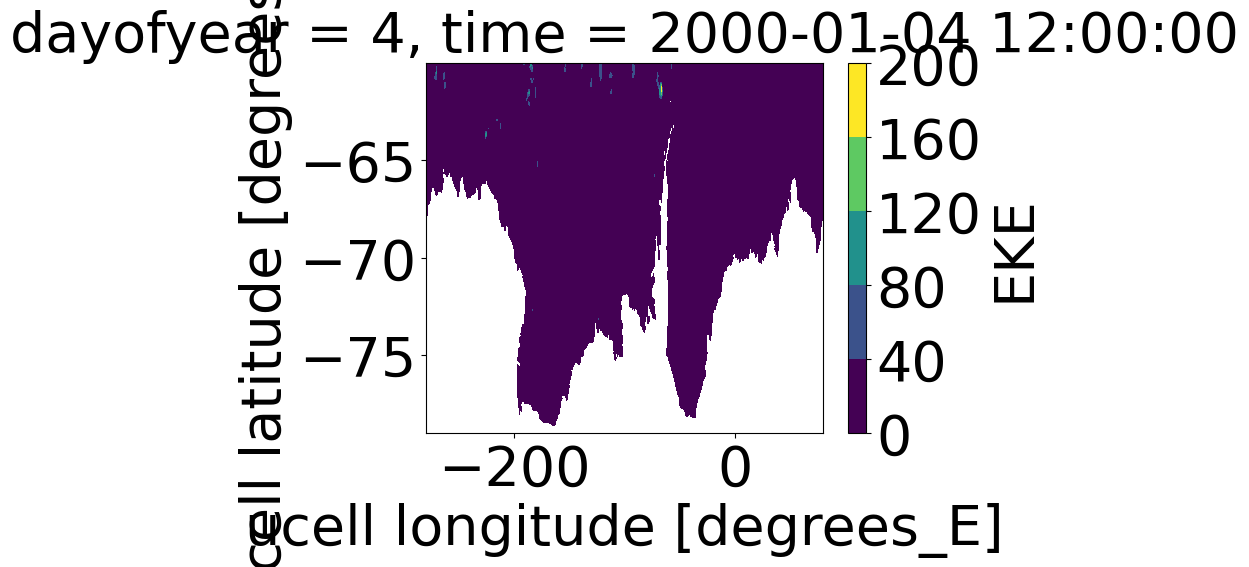

In [75]:
EKE_field.EKE.isel(time = 3).plot.contourf()

In [76]:
EKE_field.to_netcdf('/g/data/v45/qo9901/RYF_plotting/EKEsurf_accessom201_ryf_lat7960_20002010yr.nc')

# Making time series

In [17]:
EKE_field = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/EKEsurf_accessom201_ryf_lat7960_20002010yr.nc')

In [18]:
mask_shelf = xr.where(hu <600,True, False)
#isolating regions where topography is shallower than 600m

In [19]:
mask_notshelf = xr.where(hu >600,True, False)

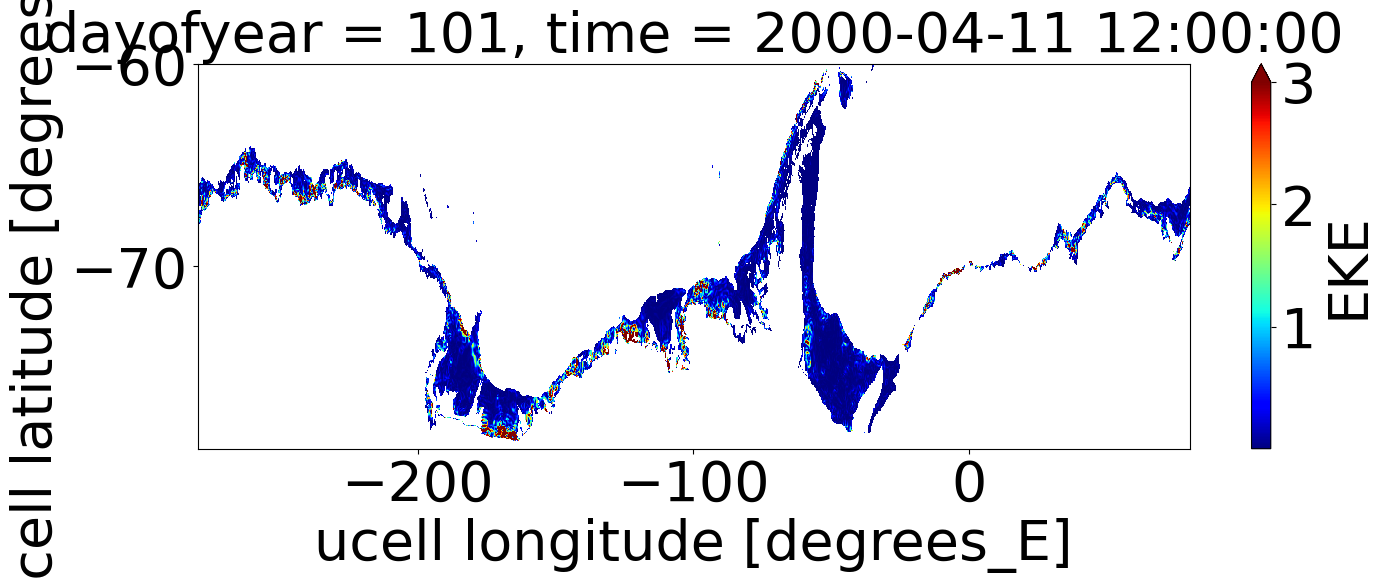

In [20]:
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(mask_shelf == True).EKE.plot(vmax = 3, cmap = 'jet')

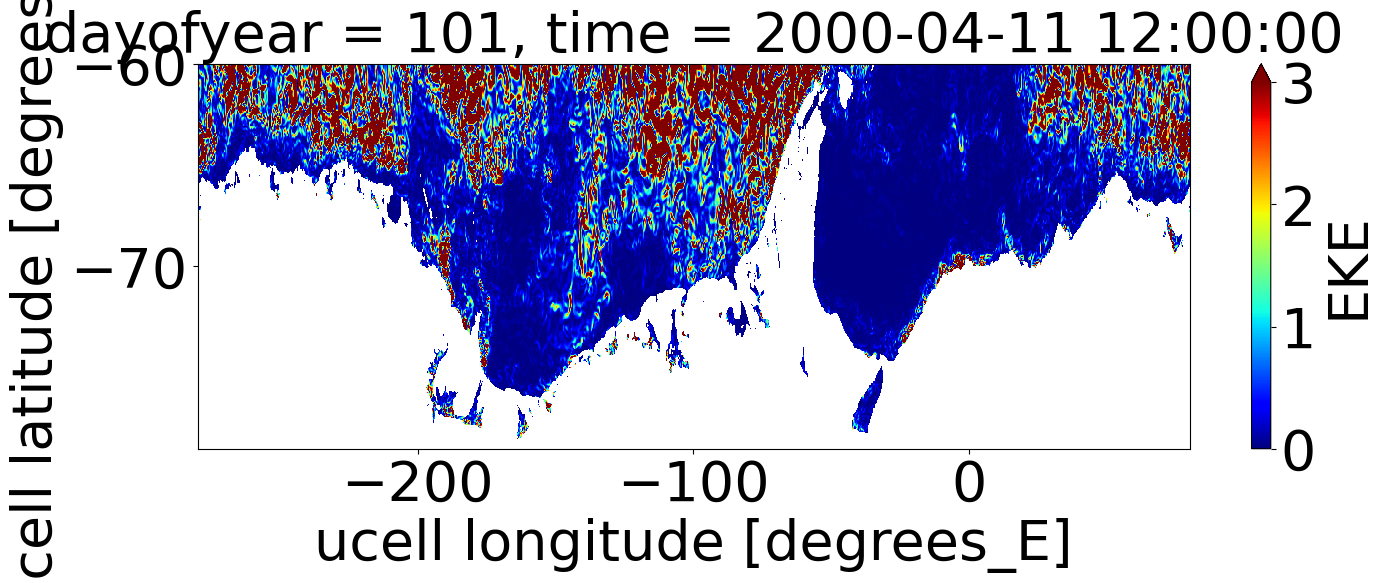

In [21]:
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(mask_shelf == False).EKE.plot(vmax = 3, cmap = 'jet')

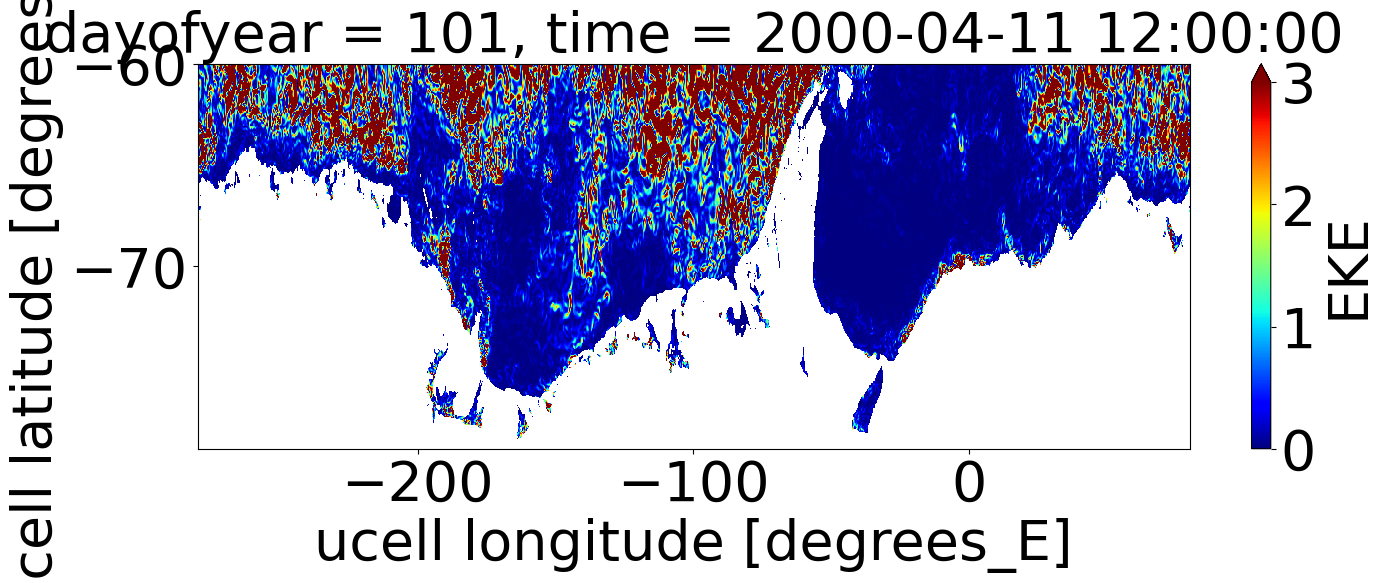

In [22]:
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(mask_notshelf == True).EKE.plot(vmax = 3, cmap = 'jet')
## this area >600m depth is what we want to remove canyons from

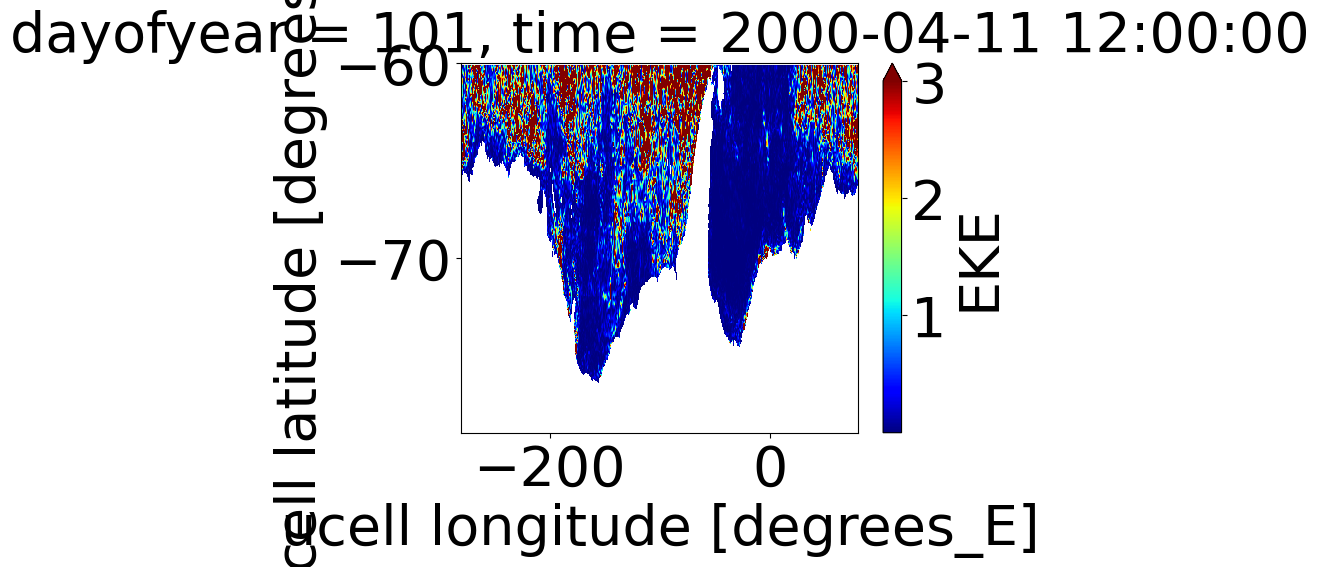

In [24]:
from scipy import ndimage
from scipy.ndimage import label, find_objects

# shrink the mask that is not of the shelf to only include largest cluster

mask_notshelf_shrink = ndimage.binary_erosion(ndimage.binary_erosion(mask_notshelf).astype(mask_notshelf.dtype)).astype(mask_notshelf.dtype)

labeled_array, num_features = label(mask_notshelf_shrink)

# Find the sizes of each cluster
cluster_sizes = np.bincount(labeled_array.ravel())
cluster_mask_one = (labeled_array ==  cluster_sizes[1:].argsort()[-1] + 1)
EKE_field.isel(time = 100).where(cluster_mask_one ==True).EKE.plot(vmax = 3, cmap = 'jet')


In [25]:
# mask for canyons where they are deeper than 600m and not part of largest southern ocean slope cluster

one_cluster_mask_xr = xr.DataArray(cluster_mask_one)

one_cluster_mask_xr = one_cluster_mask_xr.rename({'dim_0': 'yu_ocean', 'dim_1':'xu_ocean'})
one_cluster_mask_xr


<xarray.DataArray (yu_ocean: 440, xu_ocean: 3600)> Size: 2MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: yu_ocean, xu_ocean

In [26]:
def changeline_cs(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('g')
        #col.set_linewidth(2)


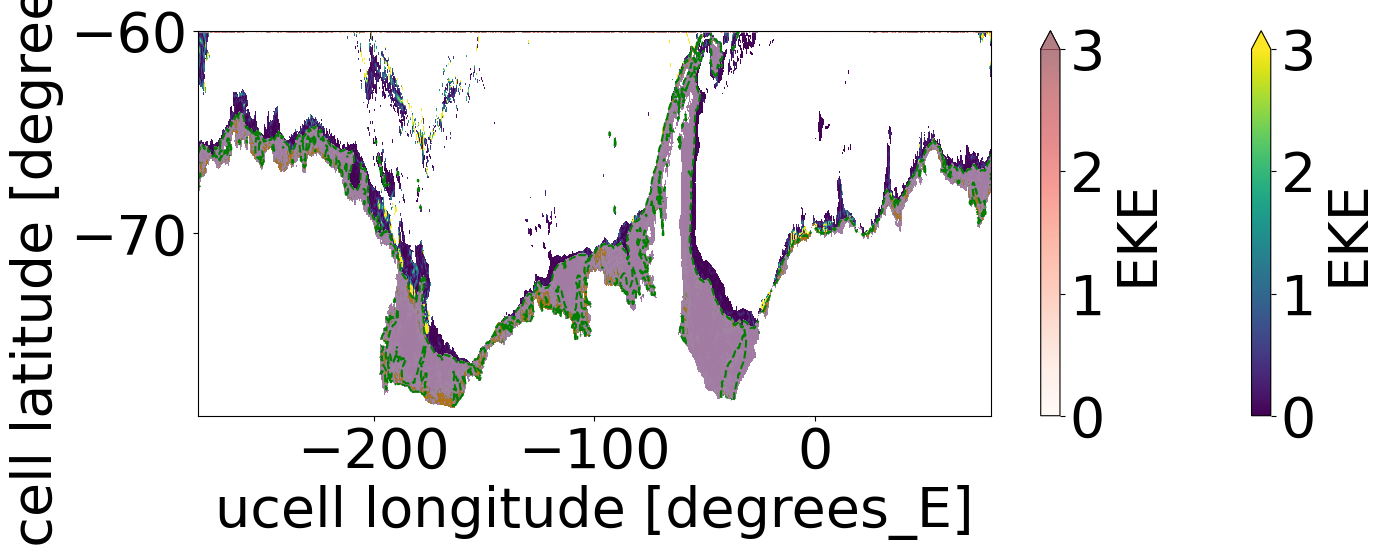

In [27]:
## showing the included and excluded regions 
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(hu<2500).EKE.plot(vmax = 3, zorder = 0)
EKE_field.isel(time = 100).where(cluster_mask_one == False).EKE.plot(alpha = 0.5, vmax = 3, cmap = 'Reds', zorder = 1) #.where(mask_notshelf ==False)

cs = hu.plot.contour( levels = [600], lw = 3, cmap = 'Greens',zorder = 2)
changeline_cs('dashed')



In [152]:
cd MW-perturb-ASC/

/home/561/qo9901/MW-perturb-ASC


In [155]:
one_cluster_mask_xr.to_netcdf('600misobath_sans_canyons_cluster_mask_xr_accessom201.nc')